In [21]:
import os
import random
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm_notebook, tnrange
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate,add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array,load_img,array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

In [22]:
def count_img(root, total, folders, total_count, text):
    for filename in tqdm(os.listdir(root)):
        if filename != ".DS_Store":
            folders.append(filename)
            ids = next(os.walk(root+'/'+filename))[2]# list of names all images in the given path
            total_count.append(len(ids))
            total +=len(ids)
    print(text)
    print("Number of images and masks = ", total)
    print("The folders containing images and masks are :", folders)
    print("Image tally accordingly :", total_count)
    return total, folders, total_count

In [23]:
def mac_equalizer(total_count):
    for i in range(len(total_count)):
        if total_count[i] % 2 != 0 :
            total_count[i] -= 1
    print("New count is :", total_count)
    print("New total = ", sum(total_count))
    return total_count,sum(total_count)

In [24]:
def upload(root, folders, X, y, text):
    count_img = 0
    count_mask = 0
    
    print(text)
    
    for file in folders : 
        image_dir_path = root+ "/" +file
        mask_dir_path =  root+ "/" +file
        
        for img_path in tqdm(sorted(glob.glob(os.path.join(image_dir_path, "*_img.png")))):
            img = load_img(img_path, color_mode = "grayscale")
            img = img_to_array(img)
            img = resize(img, (128, 128, 1), mode = 'constant', preserve_range = True)
            img = img/255.0
            X[count_img]=img 
            count_img+=1
        print("Image upload count = ", count_img)
        
        
        for mask_path in tqdm(sorted(glob.glob(os.path.join(mask_dir_path, "*_mask.png")))):
            mask = load_img(mask_path, color_mode = "grayscale")
            mask = img_to_array(mask)
            mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
            mask = mask/255.0
            y[count_mask]=mask
            count_mask+=1
        print("Mask upload count = ", count_mask)
    return X,y

In [25]:
def pre_visualize(X, y, text, ix = None) :
    
    print(text)
    for i in range(5) : 
        if ix == None :
            ix = random.randint(0, len(X)-1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
        ax1.imshow(X[ix], cmap = 'gray', interpolation = 'bilinear')
        ax1.set_title('Image')
        
        ax2.imshow(y[ix], cmap = 'gray', interpolation = 'bilinear')
        ax2.set_title('Mask')
        ix = None

In [26]:
train_text = "\t\t\t\t\t\tTraining "
valid_text = "\t\t\t\t\t\tValidation "
test_text = "\t\t\t\t\t\t\tTesting "
train_total = 0
test_total = 0
train_total_count = []
test_total_count = []
train_folders = []
test_folders = []
train_root = "/Users/anveshsk/Dropbox/capstone_data/train_local"
test_root = "/Users/anveshsk/Dropbox/capstone_data/test"

train_total, train_folders, train_total_count = count_img(train_root, train_total, train_folders, train_total_count, "Training")
test_total, test_folders, test_total_count = count_img(test_root, test_total, test_folders, test_total_count, "Testing")


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3709.31it/s]


Training
Number of images and masks =  457
The folders containing images and masks are : ['SS_EA031', 'SS_045', 'EA036_SS', 'SS', 'SS_EA_050', 'SS_3', 'SS_EA026']
Image tally accordingly : [157, 56, 45, 63, 51, 42, 43]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4096.00it/s]

Testing
Number of images and masks =  43
The folders containing images and masks are : ['SS_EA001', 'SS_EA041', 'SS_EA025', 'SS_EA034']
Image tally accordingly : [10, 10, 10, 13]


In [27]:
train_total_count, train_total = mac_equalizer(train_total_count)
test_total_count, test_total = mac_equalizer(test_total_count)

New count is : [156, 56, 44, 62, 50, 42, 42]
New total =  452
New count is : [10, 10, 10, 12]
New total =  42


In [28]:
im_width = 128
im_height = 128

X = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)

X_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)
y_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)

In [29]:
X, y = upload(train_root, train_folders, X, y, train_text)

						Training 


100%|███████████████████████████████████████████| 78/78 [00:01<00:00, 59.88it/s]


Image upload count =  78


100%|███████████████████████████████████████████| 78/78 [00:01<00:00, 77.24it/s]


Mask upload count =  78


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 59.73it/s]


Image upload count =  106


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 76.35it/s]


Mask upload count =  106


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 60.96it/s]


Image upload count =  128


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 80.92it/s]


Mask upload count =  128


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 64.25it/s]


Image upload count =  159


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 75.08it/s]


Mask upload count =  159


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 62.36it/s]


Image upload count =  184


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 75.19it/s]


Mask upload count =  184


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 60.39it/s]


Image upload count =  205


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 78.97it/s]


Mask upload count =  205


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 67.58it/s]


Image upload count =  226


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 77.57it/s]

Mask upload count =  226


In [30]:
X_test, y_test = upload(test_root, test_folders, X_test, y_test, test_text)

							Testing 


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 67.17it/s]


Image upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 76.64it/s]


Mask upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 65.38it/s]


Image upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 71.72it/s]


Mask upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 63.49it/s]


Image upload count =  15


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 76.89it/s]


Mask upload count =  15


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 57.79it/s]


Image upload count =  21


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 75.84it/s]

Mask upload count =  21


In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [32]:
len(X_train)

180

In [33]:
len(X_valid)

46

						Training 


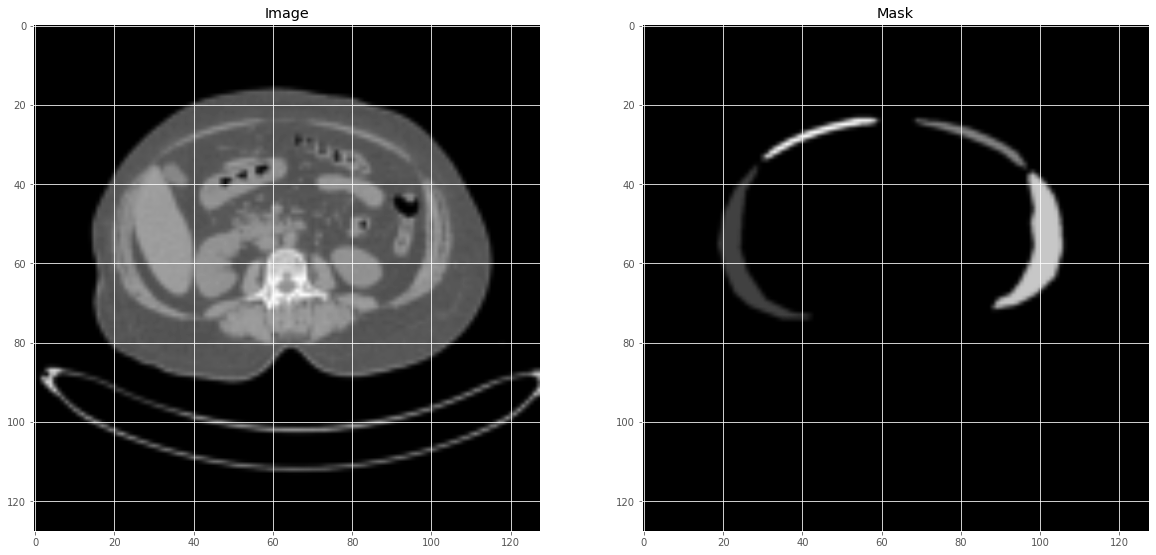

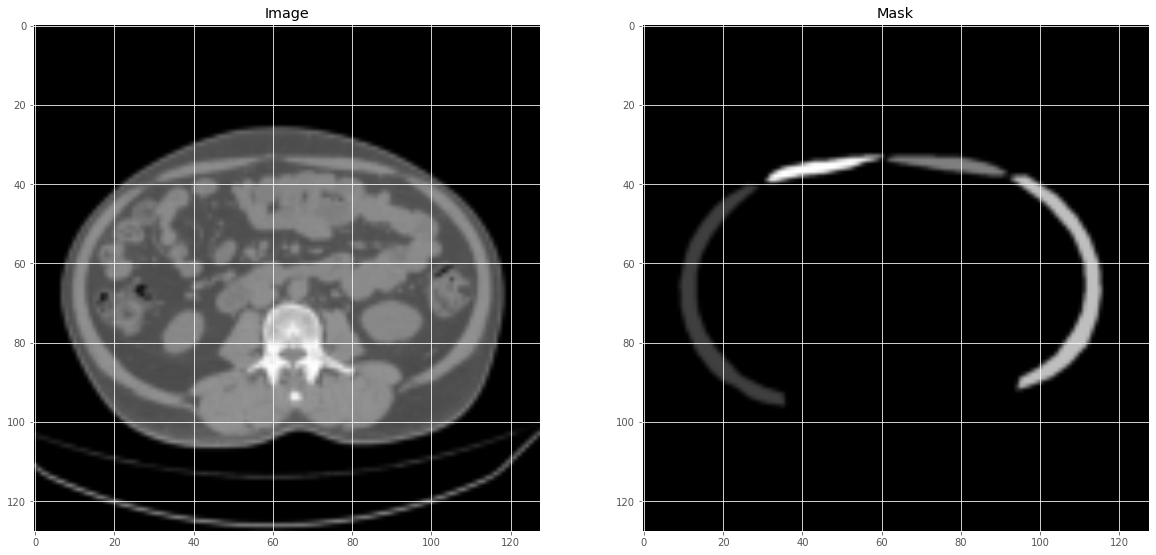

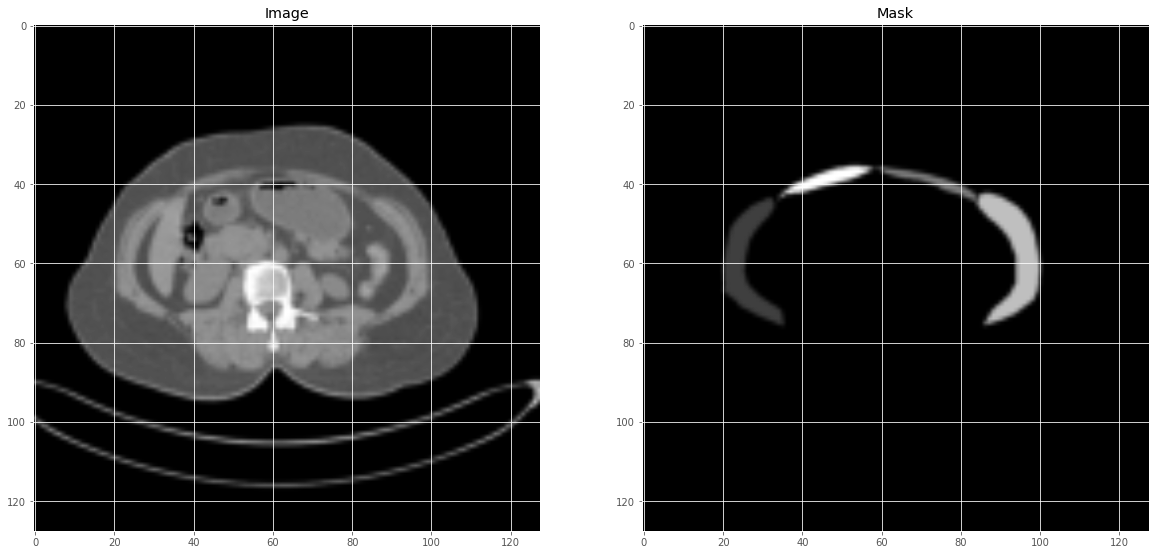

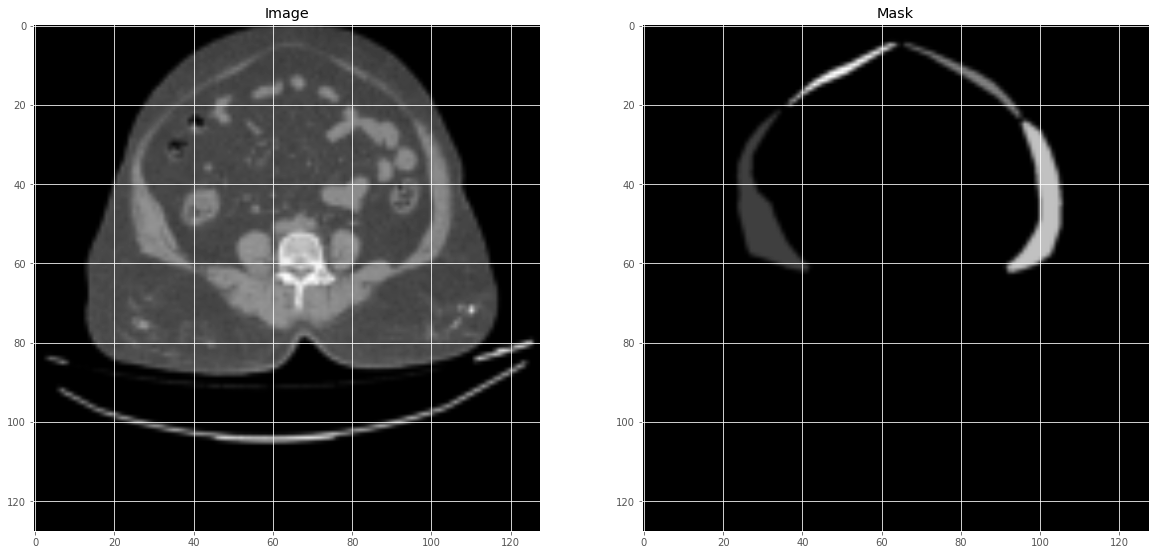

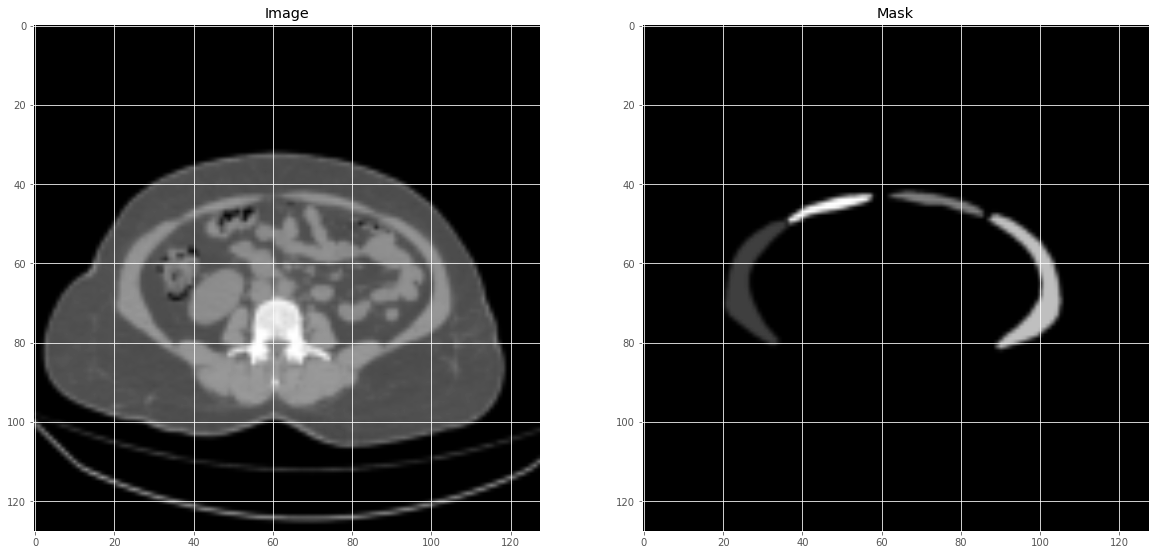

In [34]:
pre_visualize(X_train, y_train, train_text)

						Validation 


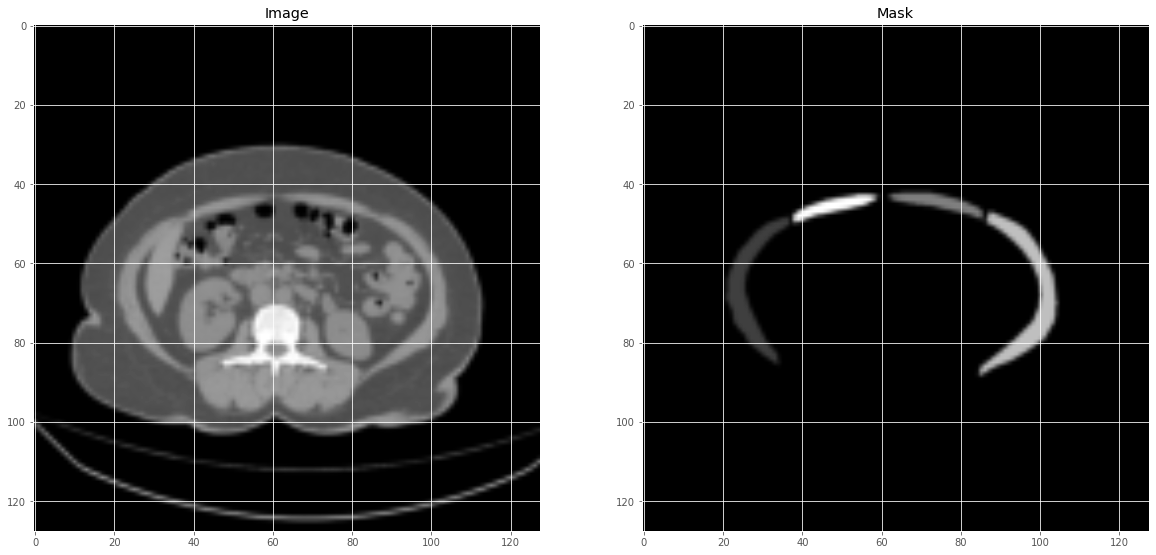

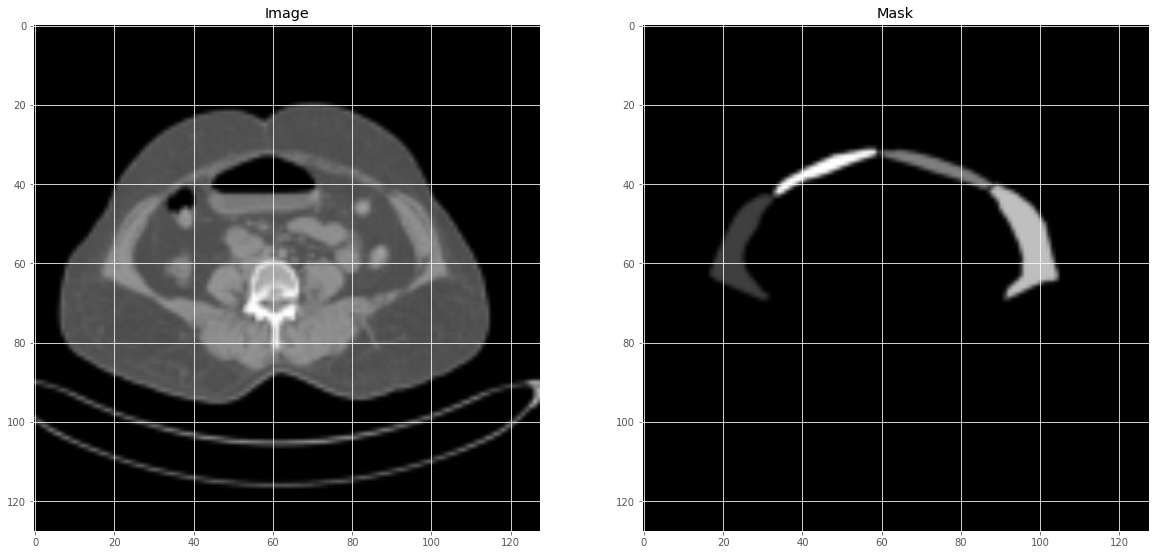

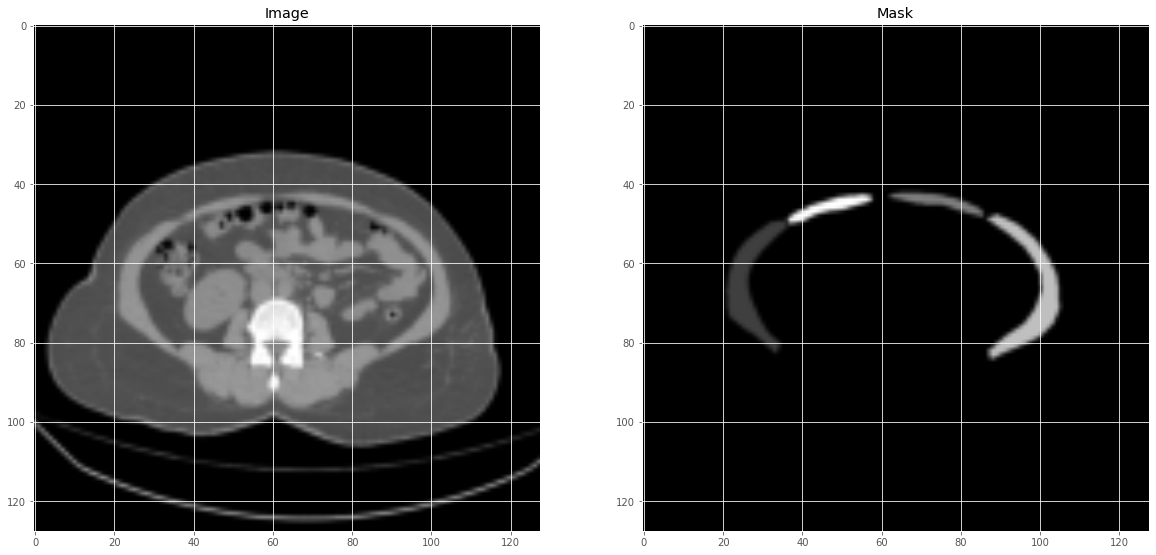

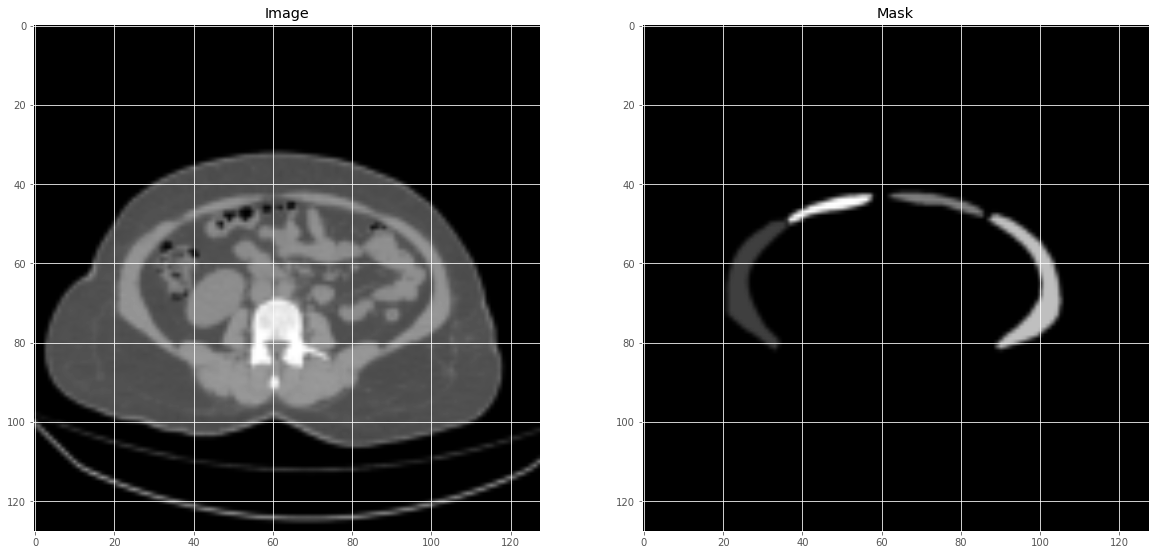

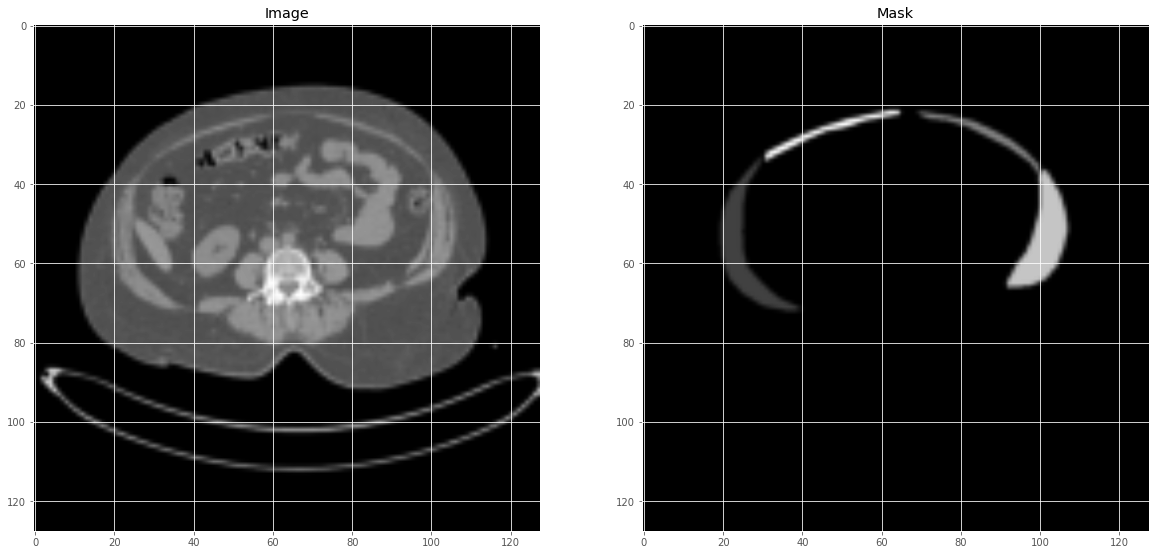

In [35]:
pre_visualize(X_valid, y_valid, valid_text)

							Testing 


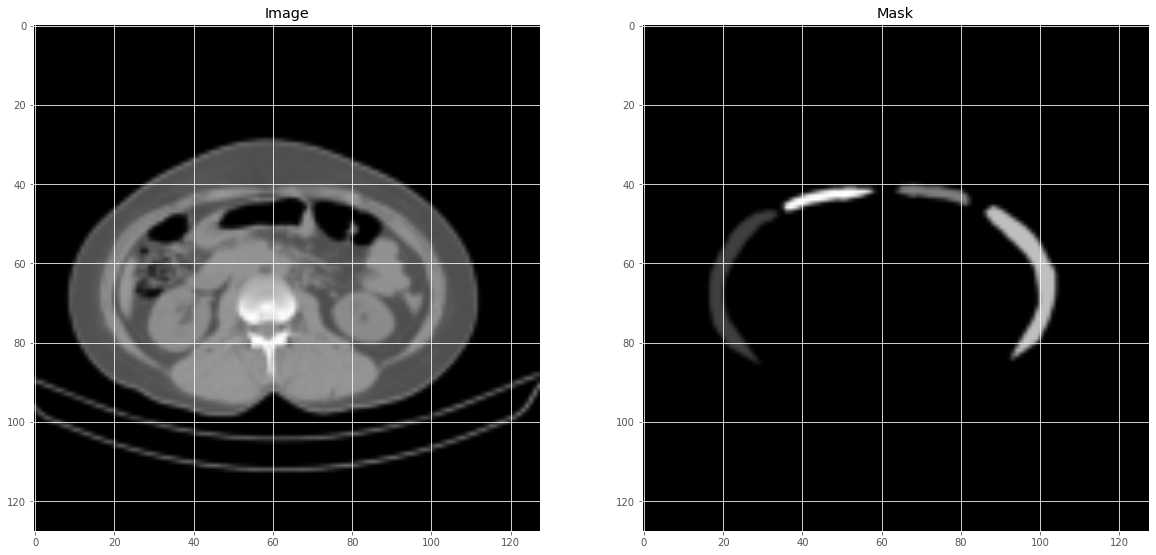

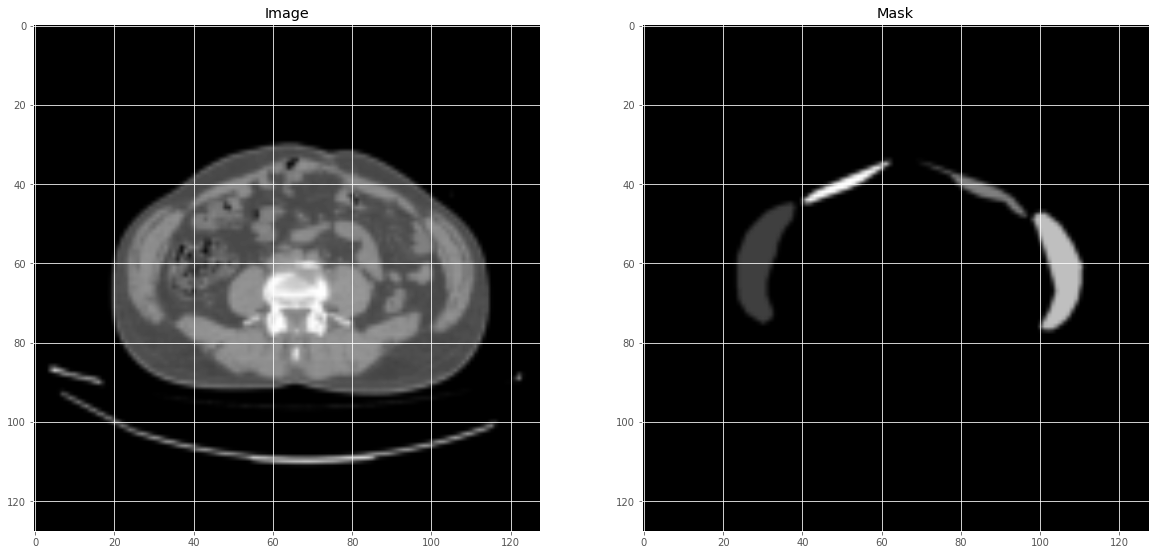

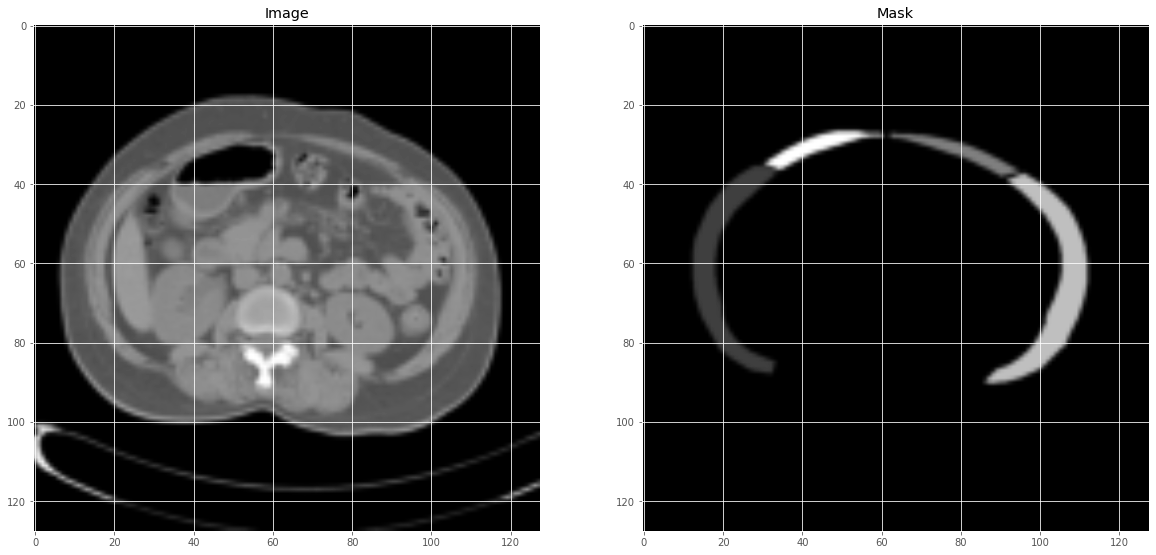

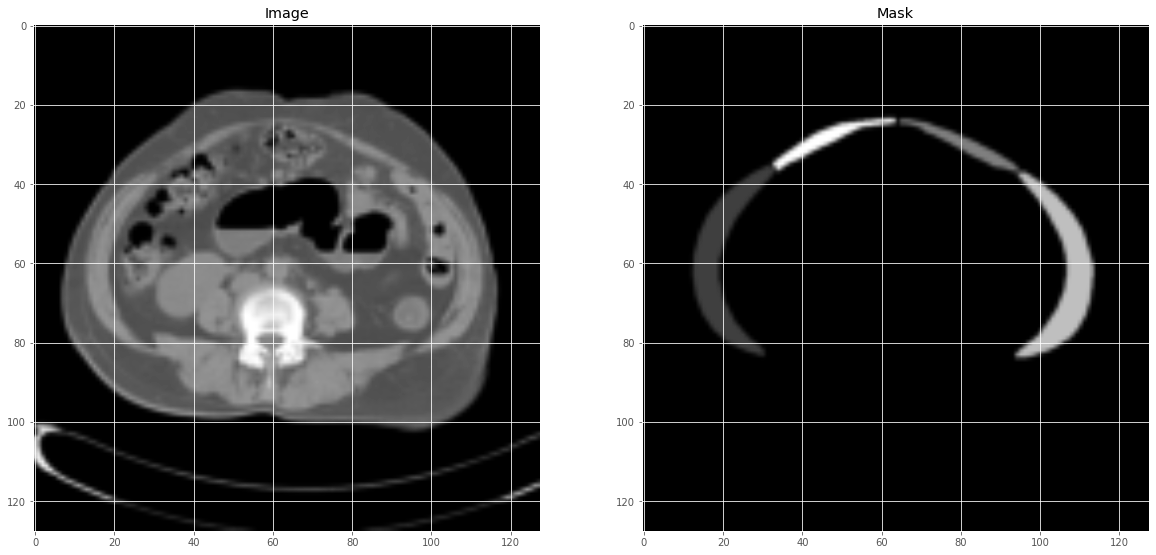

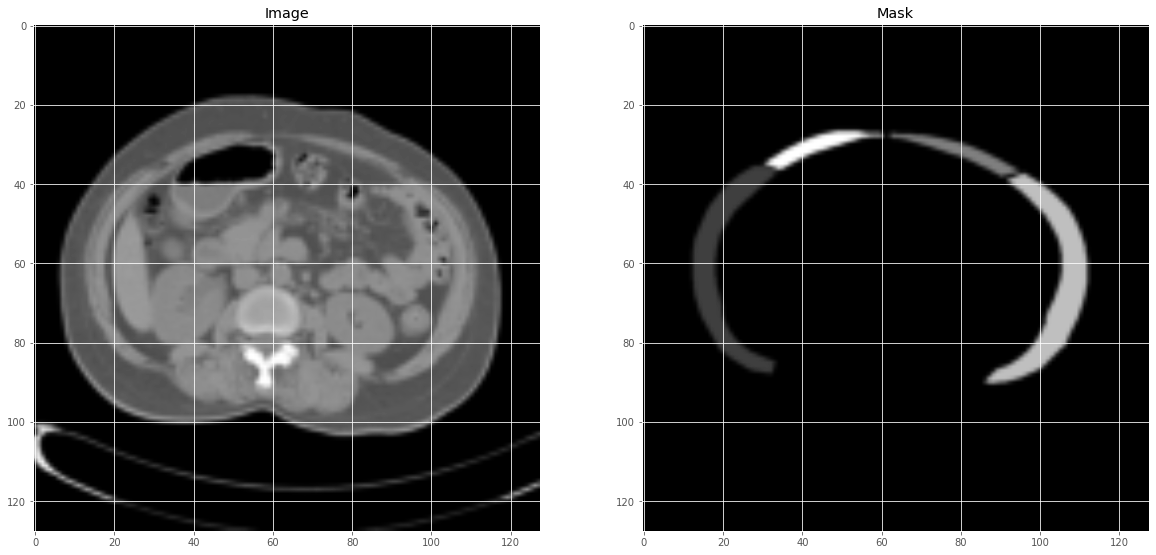

In [36]:
pre_visualize(X_test, y_test, test_text)

In [37]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [38]:
#UNet Architecture 
def get_unet(input_img, n_filters = 16, dropout = 0.5, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [39]:
from keras import backend as K


def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (2. * intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + K.epsilon())
    return 1. - val

In [40]:
from keras import backend as K
def iou_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) - intersection + K.epsilon())
    return 1. - val

In [41]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy"])

2023-03-05 11:36:23.445137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 8, 8, 256)    0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 256)    590080      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

                                )                                 'activation_1[0][0]']           
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128, 128, 16  64         ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
          

In [43]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_local_stdUNet_B16D50E100-tgs-salt_run1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [44]:
results = model.fit(X_train, y_train, batch_size=16, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.9335 - accuracy: 0.1634
Epoch 1: val_loss improved from inf to 0.95048, saving model to model_local_stdUNet_B16D50E100-tgs-salt_run1.h5
12/12 [==============================] - 19s 1s/step - loss: 0.9335 - accuracy: 0.1634 - val_loss: 0.9505 - val_accuracy: 0.0826 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.8985 - accuracy: 0.6140
Epoch 2: val_loss did not improve from 0.95048
12/12 [==============================] - 13s 1s/step - loss: 0.8985 - accuracy: 0.6140 - val_loss: 0.9540 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.8696 - accuracy: 0.7612
Epoch 3: val_loss did not improve from 0.95048
12/12 [==============================] - 13s 1s/step - loss: 0.8696 - accuracy: 0.7612 - val_loss: 1.0000 - val_accuracy: 0.8970 - lr: 0.0010
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.8397 - accur

12/12 [==============================] - 13s 1s/step - loss: 0.1316 - accuracy: 0.9203 - val_loss: 0.2245 - val_accuracy: 0.9221 - lr: 0.0010
Epoch 26/100
12/12 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9203
Epoch 26: val_loss improved from 0.22455 to 0.19266, saving model to model_local_stdUNet_B16D50E100-tgs-salt_run1.h5
12/12 [==============================] - 13s 1s/step - loss: 0.1153 - accuracy: 0.9203 - val_loss: 0.1927 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 27/100
12/12 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9203
Epoch 27: val_loss improved from 0.19266 to 0.17871, saving model to model_local_stdUNet_B16D50E100-tgs-salt_run1.h5
12/12 [==============================] - 13s 1s/step - loss: 0.1029 - accuracy: 0.9203 - val_loss: 0.1787 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 28/100
12/12 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9203
Epoch 28: val_loss improved from 0.17871 to 0.15567,

12/12 [==============================] - 13s 1s/step - loss: 0.0255 - accuracy: 0.9203 - val_loss: 0.0307 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 51/100
12/12 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9203
Epoch 51: val_loss improved from 0.03075 to 0.02570, saving model to model_local_stdUNet_B16D50E100-tgs-salt_run1.h5
12/12 [==============================] - 13s 1s/step - loss: 0.0244 - accuracy: 0.9203 - val_loss: 0.0257 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 52/100
12/12 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9203
Epoch 52: val_loss did not improve from 0.02570
12/12 [==============================] - 13s 1s/step - loss: 0.0256 - accuracy: 0.9203 - val_loss: 0.0282 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 53/100
12/12 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9203
Epoch 53: val_loss improved from 0.02570 to 0.02211, saving model to model_local_stdUNet_B16D50E100-tgs-salt_run1.h5
12/1

Epoch 76/100
12/12 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9203
Epoch 76: val_loss improved from 0.01569 to 0.01511, saving model to model_local_stdUNet_B16D50E100-tgs-salt_run1.h5
12/12 [==============================] - 12s 1s/step - loss: 0.0178 - accuracy: 0.9203 - val_loss: 0.0151 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 77/100
12/12 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9203
Epoch 77: val_loss did not improve from 0.01511
12/12 [==============================] - 12s 1s/step - loss: 0.0176 - accuracy: 0.9203 - val_loss: 0.0152 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 78/100
12/12 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9203
Epoch 78: val_loss improved from 0.01511 to 0.01463, saving model to model_local_stdUNet_B16D50E100-tgs-salt_run1.h5
12/12 [==============================] - 12s 1s/step - loss: 0.0173 - accuracy: 0.9203 - val_loss: 0.0146 - val_accuracy: 0.9223 - lr: 0.0010
Epoc

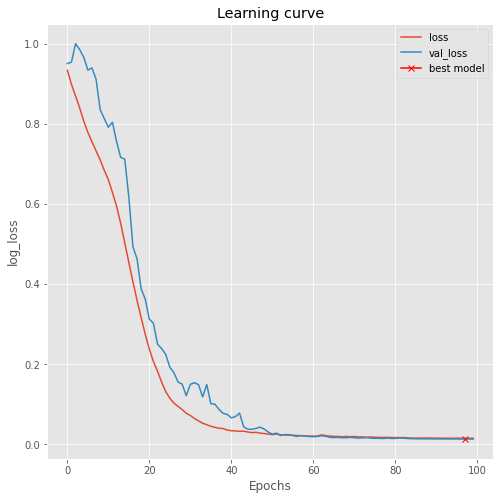

In [45]:
#plotting Learning curve ( log_loss vs epochs)
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [46]:
# load the best model
model.load_weights('model_local_stdUNet_B16D50E100-tgs-salt_run1.h5')

In [47]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_train, y_train, verbose=1)
model.evaluate(X_valid, y_valid, verbose=1)
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 294ms/step - loss: 0.0879 - accuracy: 0.9246


[0.087901771068573, 0.9245808720588684]

In [48]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 265ms/step


In [49]:
#Function for viewing plots and predictions
def plot_sample(X, y, preds,text, ix=None):
    """Function to plot the results"""
    print(text) 
    
    for i in range(5) : 
        if ix is None:
            ix = random.randint(0, len(X)-1)
            
        fig, ax = plt.subplots(1, 3, figsize=(25, 15))
        ax[0].imshow(X[ix], cmap='gray')
        ax[0].set_title('Input')

        ax[1].imshow(y[ix].squeeze(),cmap='gray')
        ax[1].set_title('Mask')


        ax[2].imshow(preds[ix].squeeze(),cmap='gray')
        ax[2].set_title('Mask Predicted')
        
        d_loss = dice_loss(y[ix],preds[ix]).numpy()
        d_loss = round(d_loss*100, 3)
        
        i_loss = iou_loss(y[ix],preds[ix]).numpy()
        i_loss = round(i_loss*100, 3)
        
        text_1 = "Dice loss of image " + str(ix) +  " = " + str(d_loss) + " %"
        text_2 = "IoU loss of image " + str(ix) +  " = " + str(i_loss) + " %"
        plt.figtext(0.4, 0.2, text_1, fontsize=18)
        plt.figtext(0.4, 0.18, text_2, fontsize=18)
        
        ix = None

						Training 


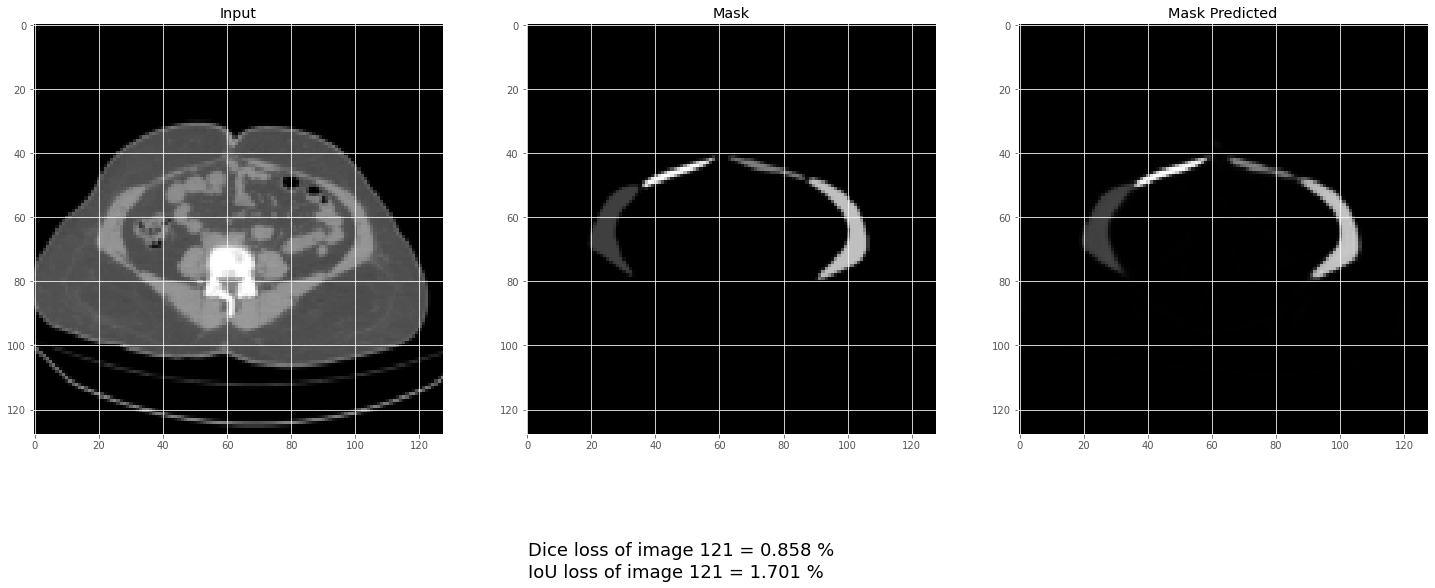

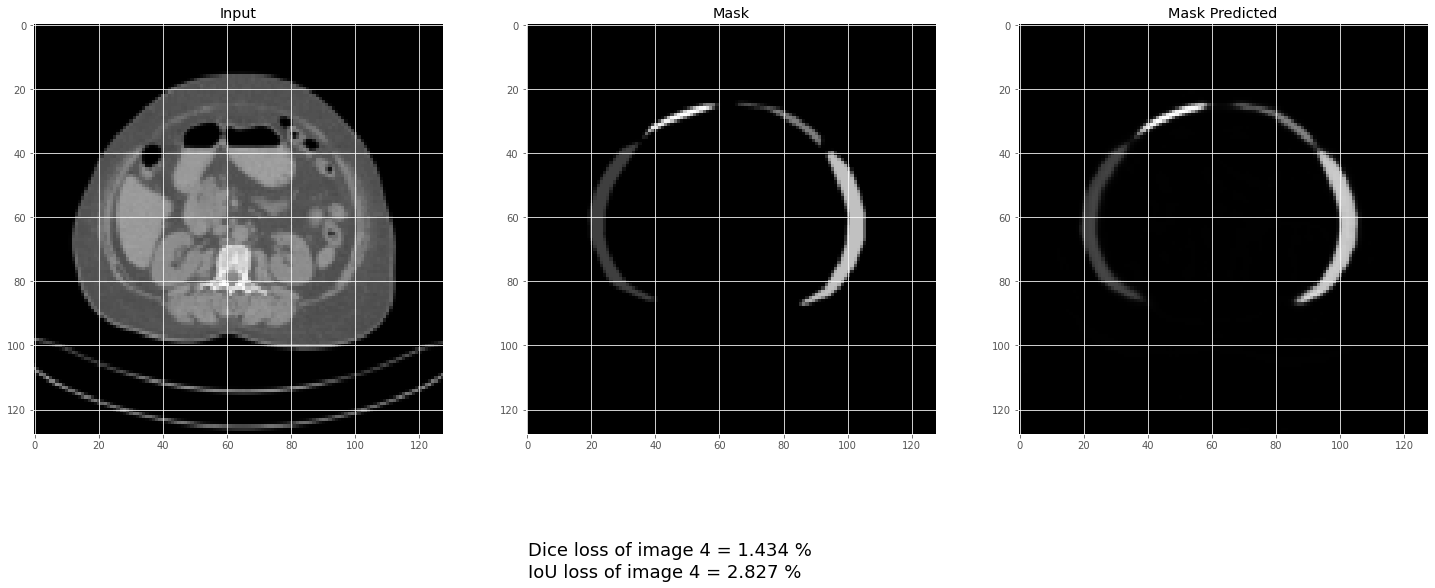

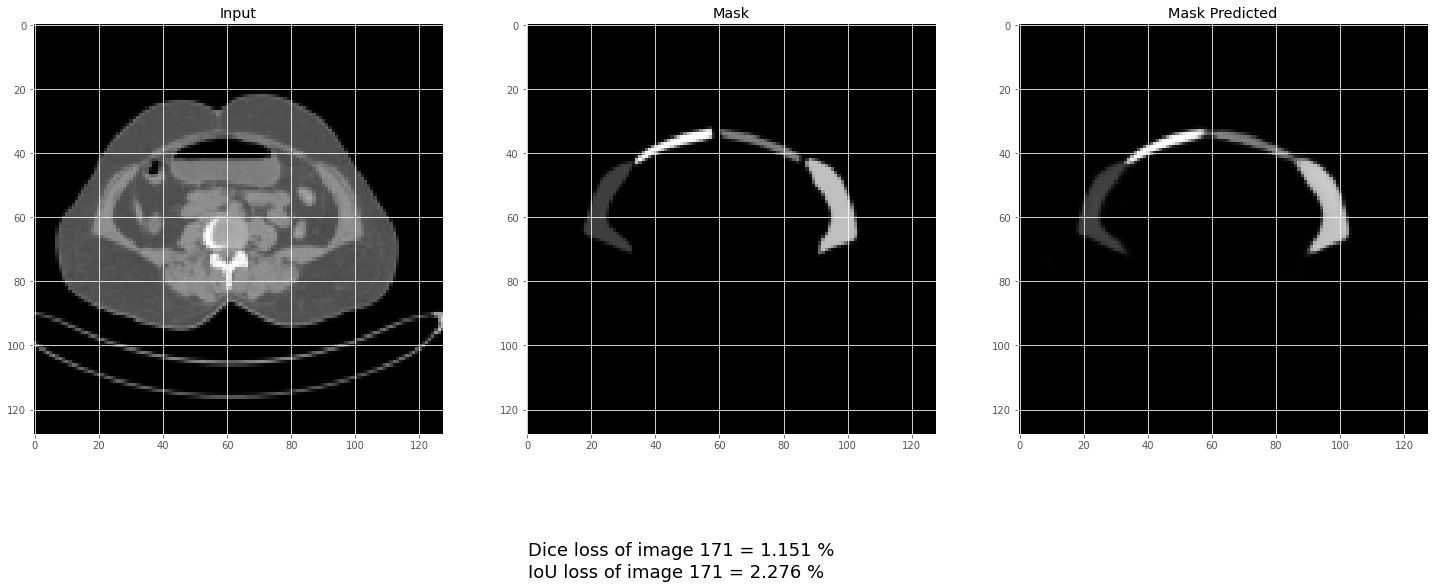

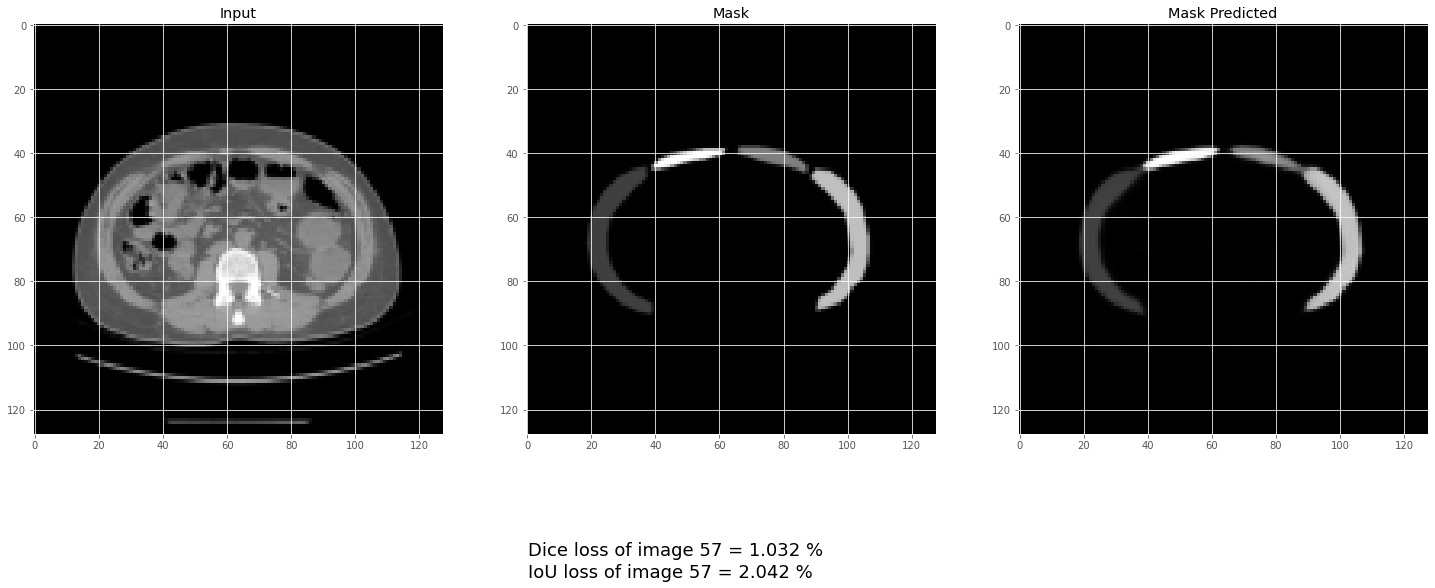

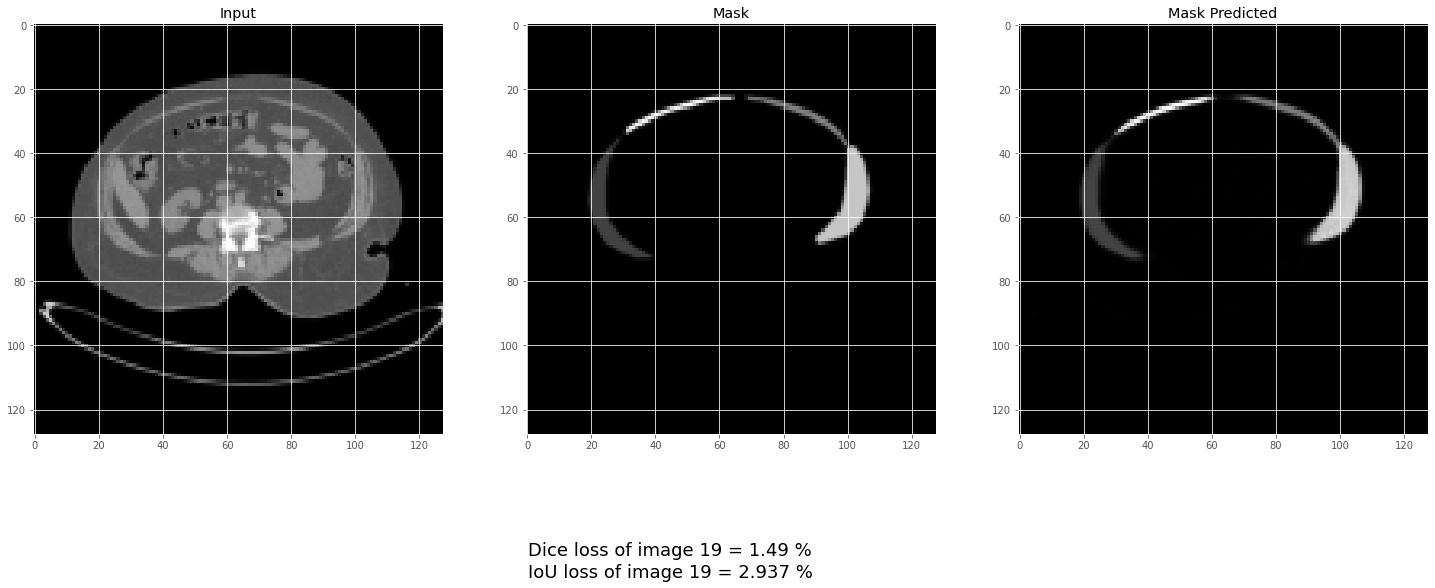

In [50]:
plot_sample(X_train, y_train, preds_train, train_text)

						Validation 


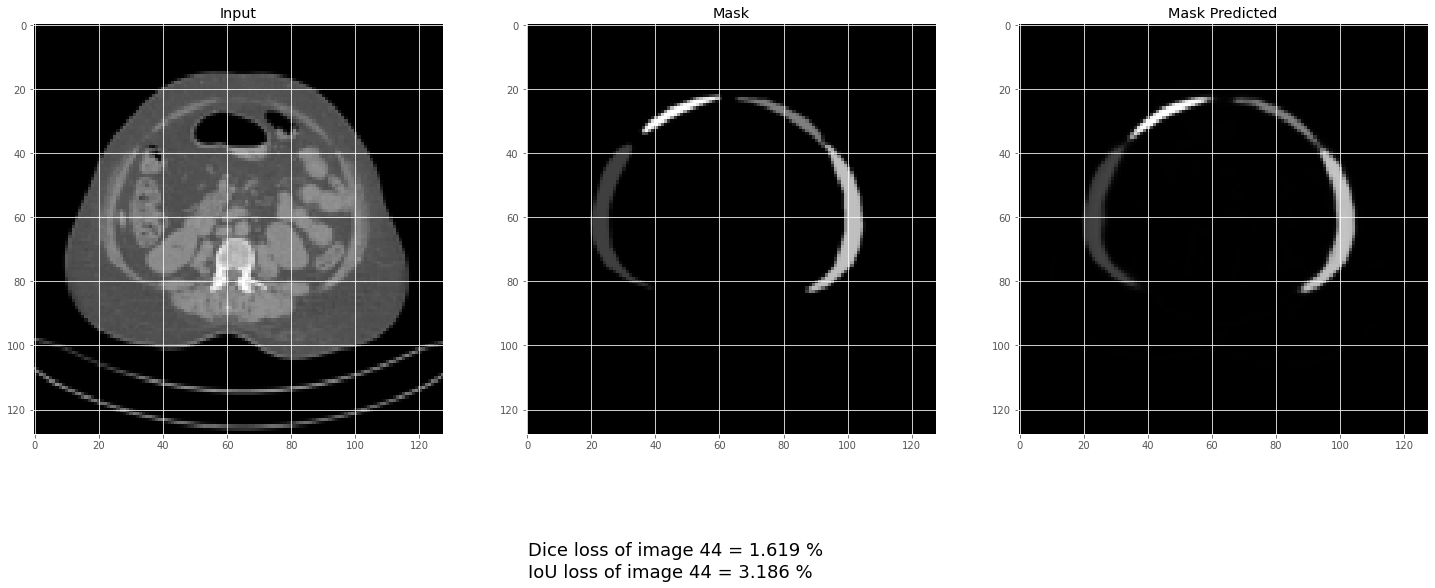

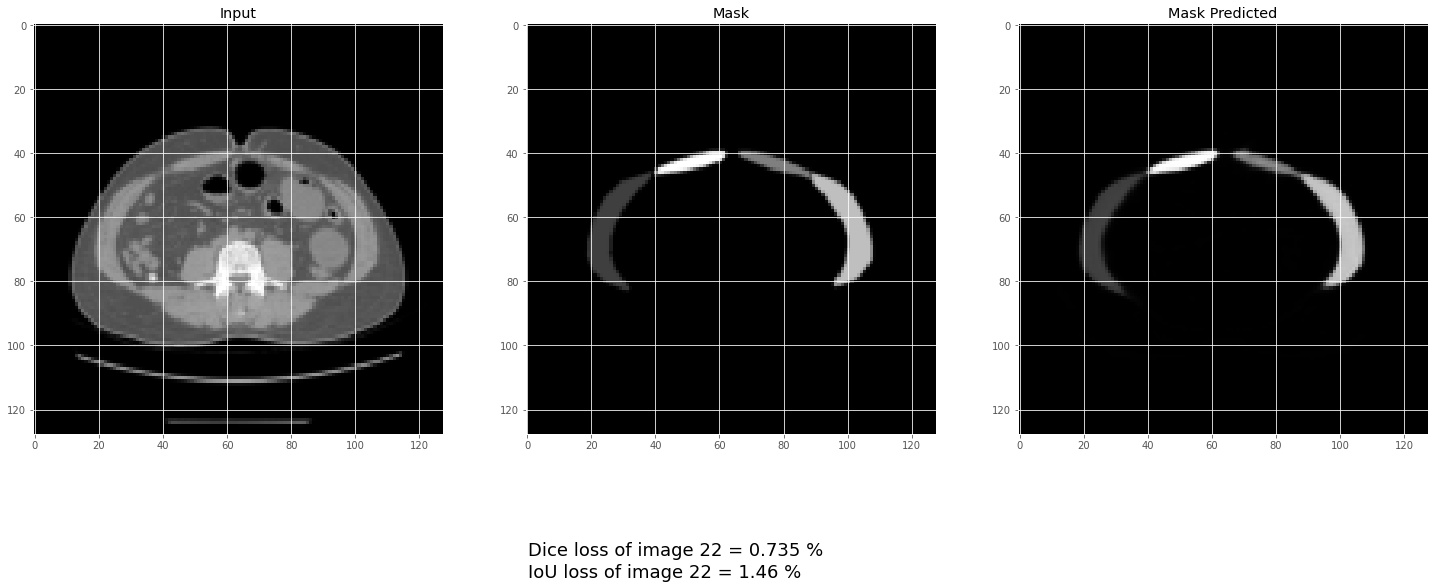

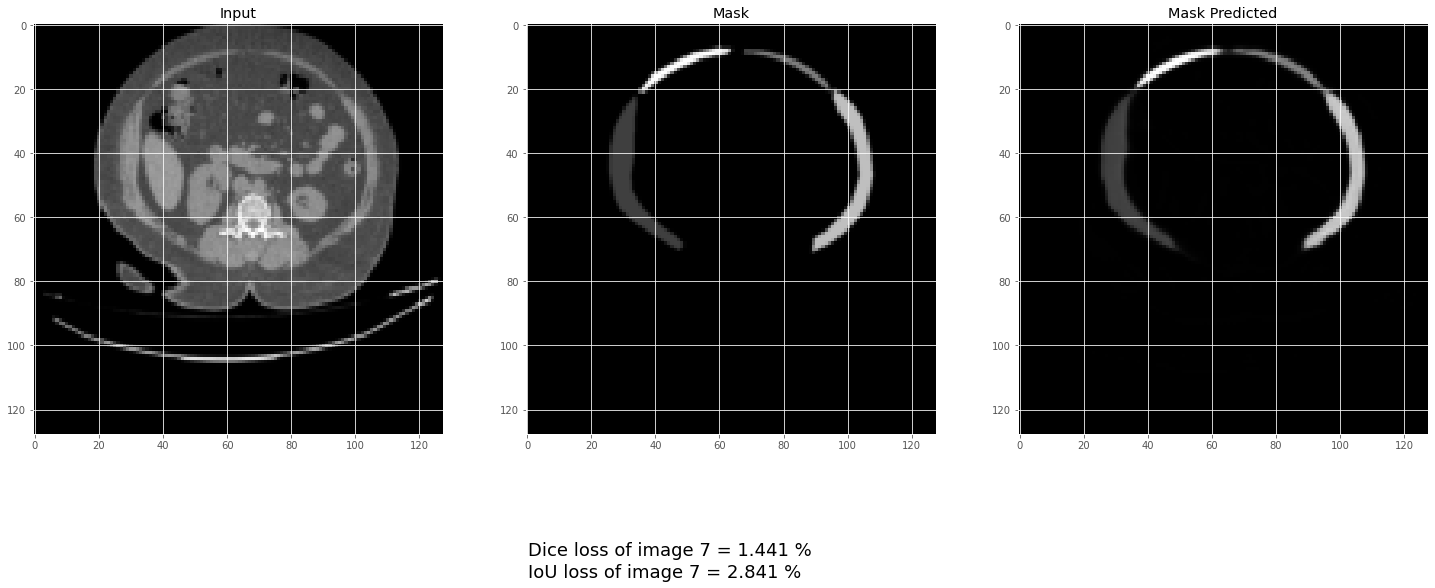

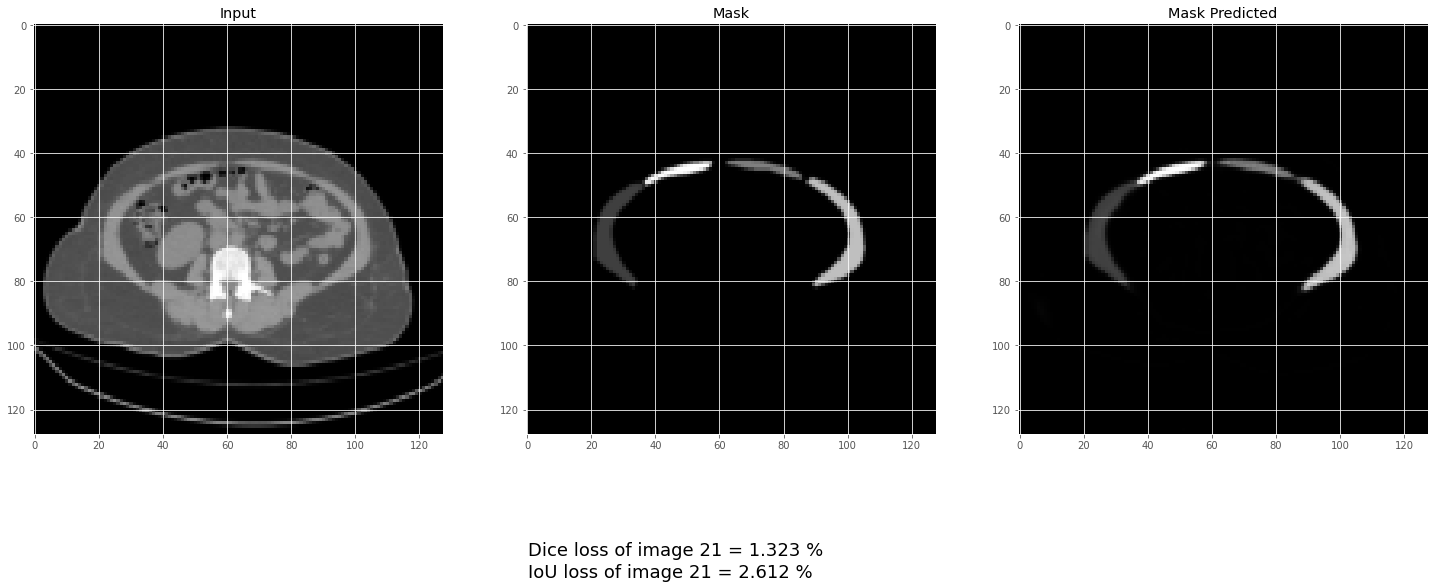

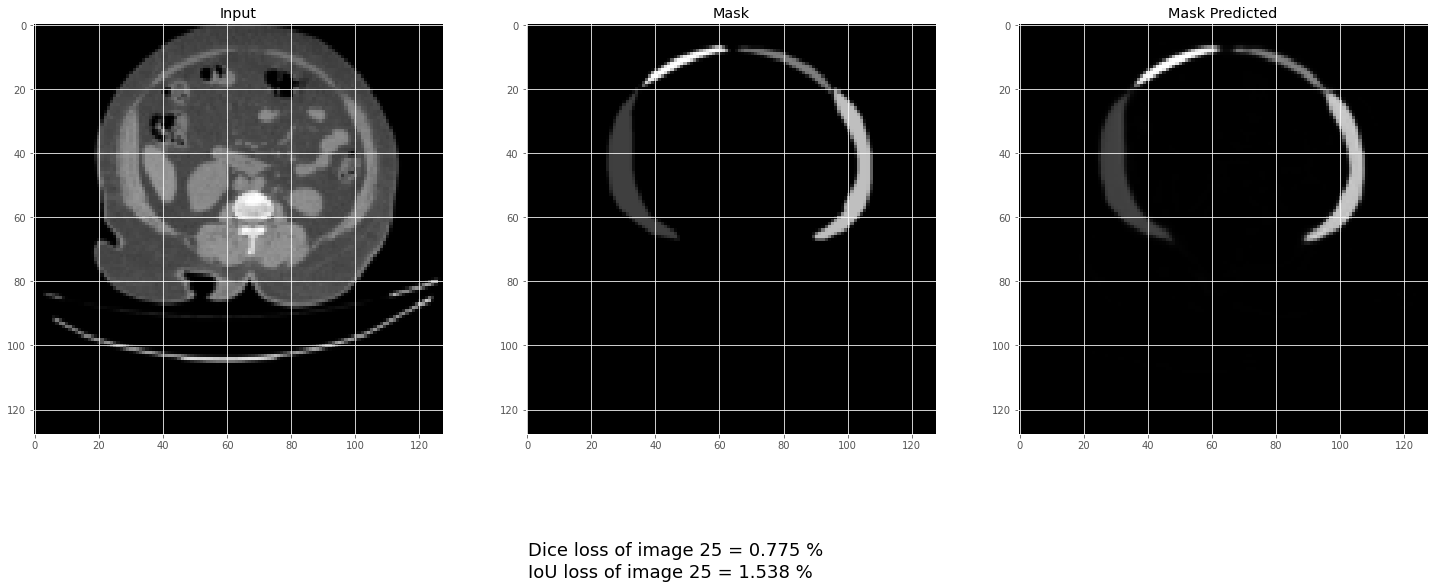

In [51]:
plot_sample(X_valid, y_valid, preds_val, valid_text)

							Testing 


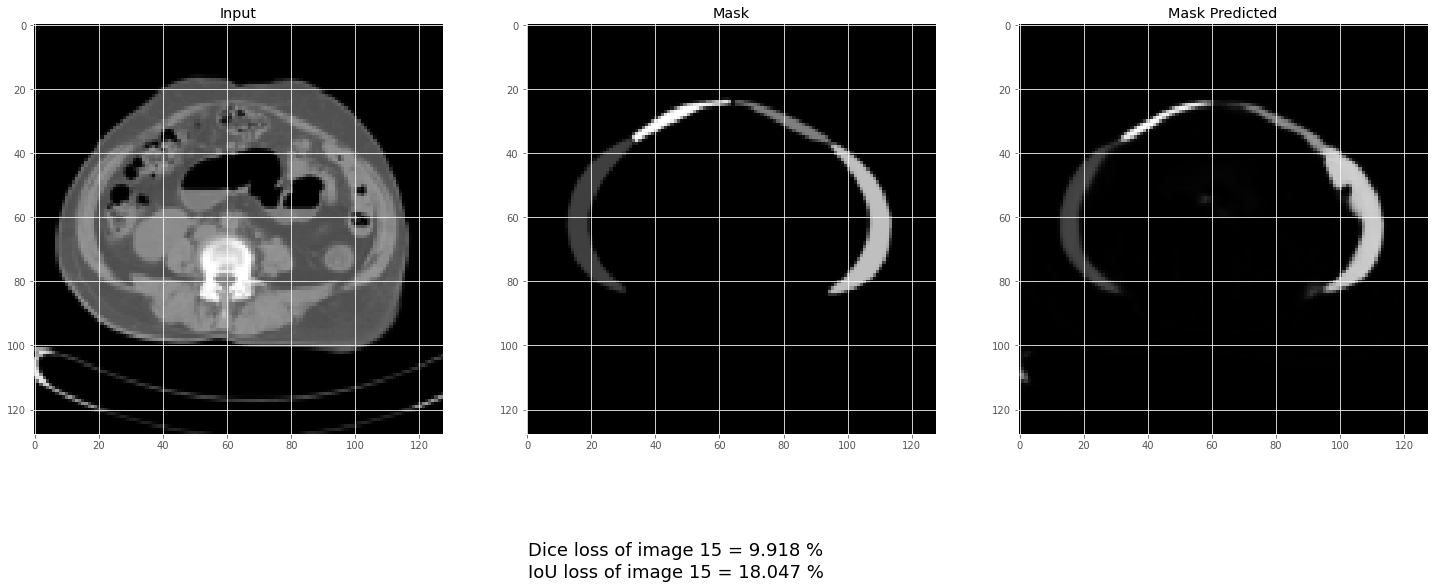

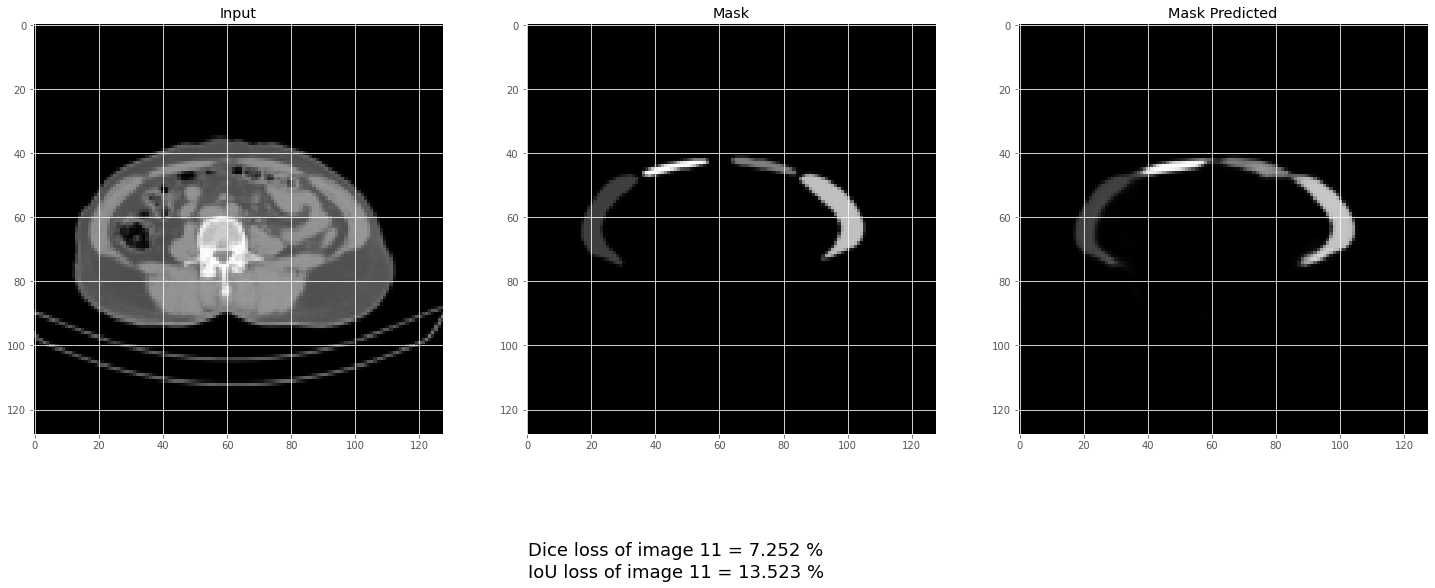

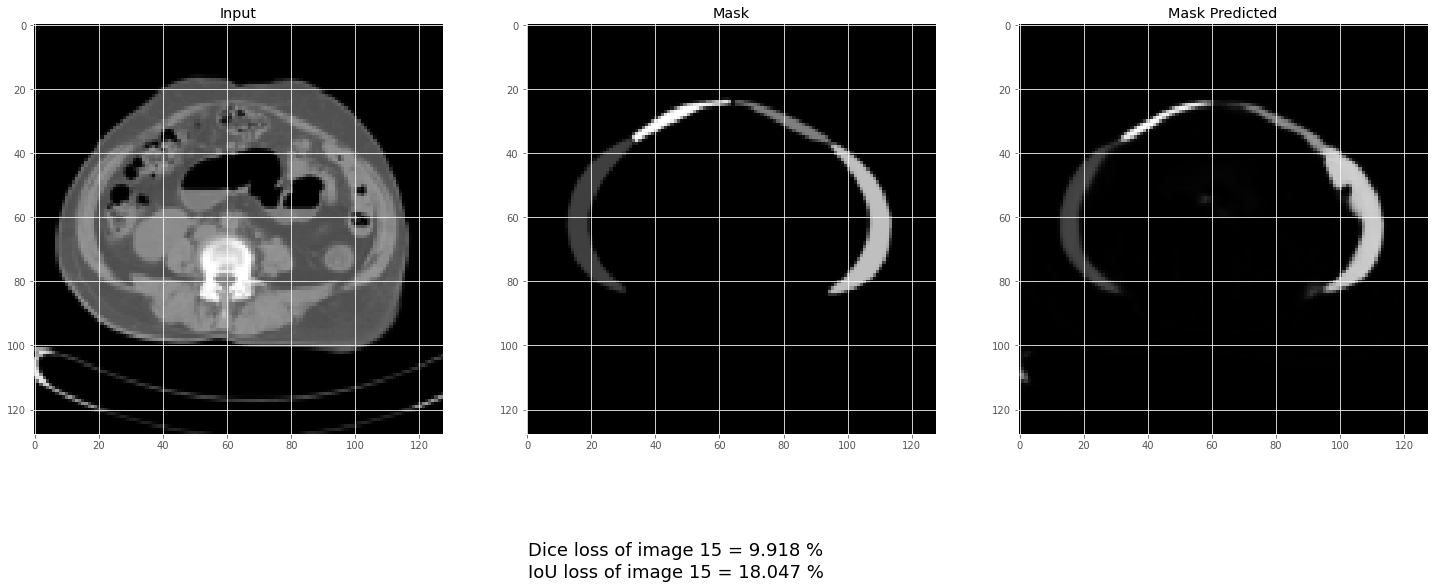

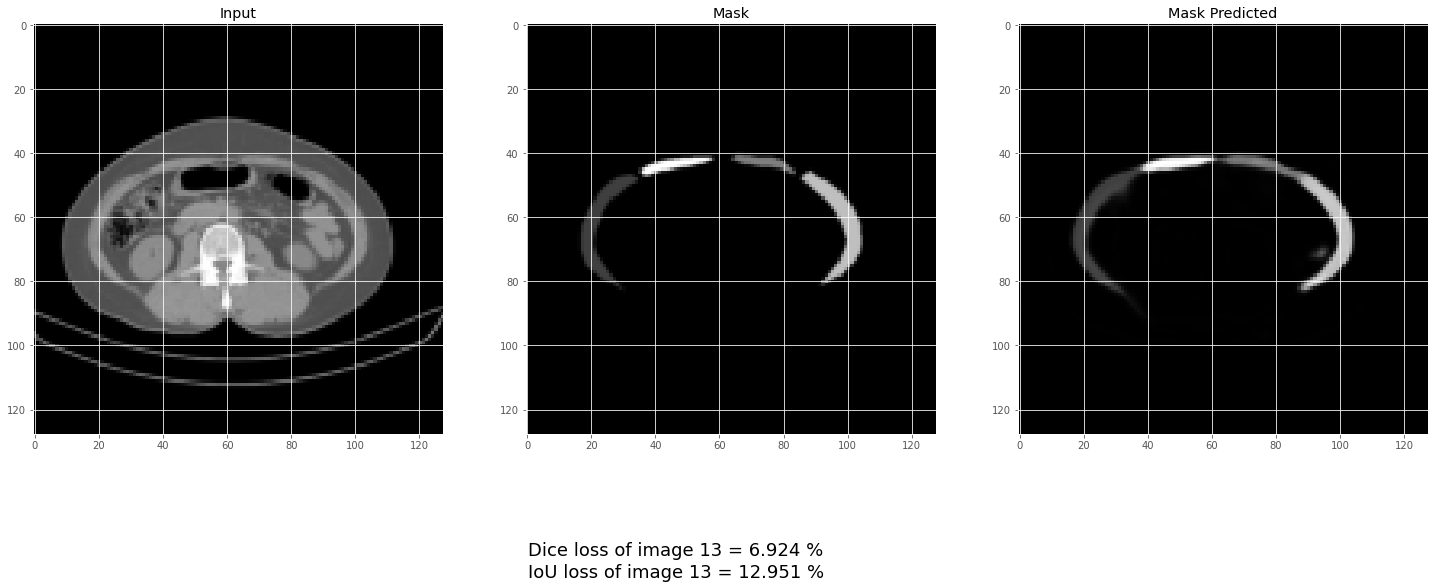

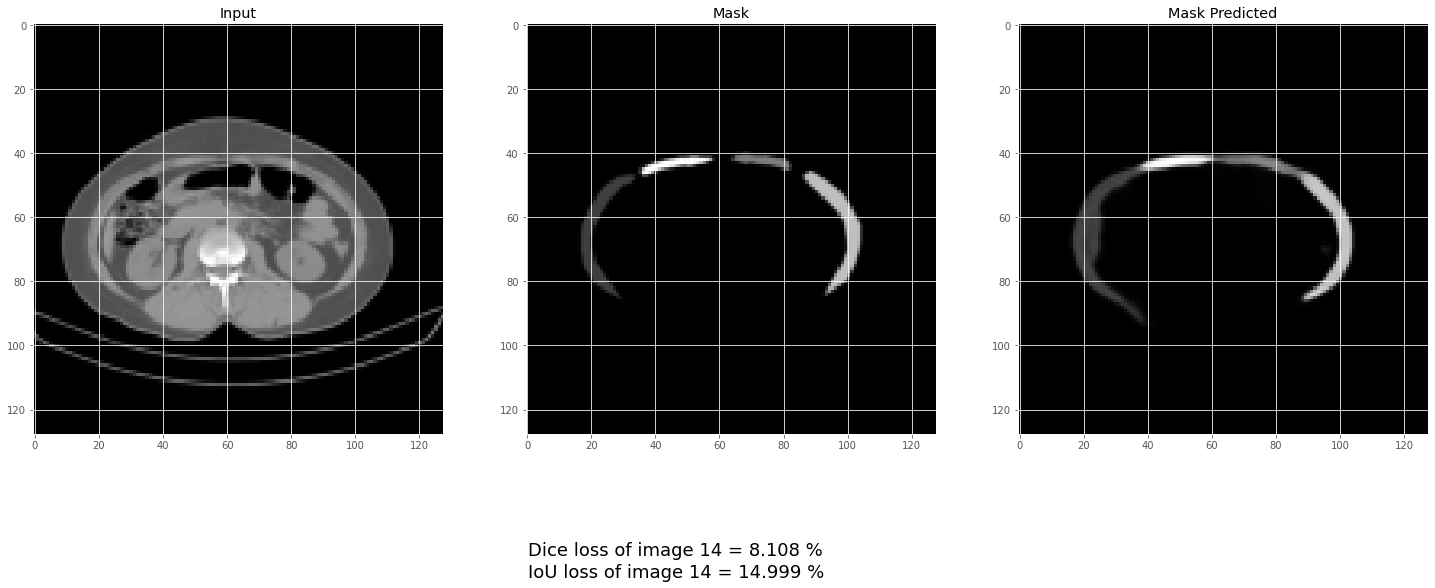

In [52]:
plot_sample(X_test, y_test, preds_test, test_text)

Resizing and Results

In [53]:
def upload_resize(root, folders, X, y, text):
    count_img = 0
    count_mask = 0
    
    print(text)
    
    for file in folders : 
        image_dir_path = root+ "/" +file
        mask_dir_path =  root+ "/" +file
        
        for img_path in tqdm(sorted(glob.glob(os.path.join(image_dir_path, "*_img.png")))):
            img = load_img(img_path, color_mode = "grayscale")
            img = img_to_array(img)
            img = resize(img, (512, 512, 1), mode = 'constant', preserve_range = True)
            img = img/255.0
            X[count_img]=img 
            count_img+=1
        print("Image upload count = ", count_img)
        
        
        for mask_path in tqdm(sorted(glob.glob(os.path.join(mask_dir_path, "*_mask.png")))):
            mask = load_img(mask_path, color_mode = "grayscale")
            mask = img_to_array(mask)
            mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
            mask = mask/255.0
            y[count_mask]=mask
            count_mask+=1
        print("Mask upload count = ", count_mask)
    return X,y

In [54]:
def avg_loss():
    d_loss_train = 0
    d_loss_valid = 0
    d_loss_test = 0

    temp = 0

    d_loss_train_list = []
    d_loss_valid_list = []
    d_loss_test_list = []
    
    for i in tqdm(range(0,len(X_train))):
        #temp = resize(preds_train[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_train = dice_loss(y_train[i],preds_train[i]).numpy()
        d_loss_train_list.append(d_loss_train)
        
    #d_loss_train_std = statistics.stdev(d_loss_train_list)
    #d_loss_train_avg = statistics.mean(d_loss_train_list)
    
    temp = 0
    
    
    for i in tqdm(range(0,len(X_valid))):
        #temp = resize(preds_val[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_valid = dice_loss(y_valid[i],preds_val[i]).numpy()
        d_loss_valid_list.append(d_loss_valid)
        
    temp = 0
    
    for i in tqdm(range(0,len(X_test))):
        #temp = resize(preds_test[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_test = dice_loss(y_test[i],preds_test[i]).numpy()
        d_loss_test_list.append(d_loss_test)
        
        

    #d_loss_valid_std = statistics.stdev(d_loss_valid_list)
    #d_loss_valid_avg = statistics.mean(d_loss_valid_list)
    return d_loss_train_list, d_loss_valid_list, d_loss_test_list
#d_loss_train_avg,d_loss_valid_avg,d_loss_train_std,d_loss_valid_std


In [55]:
a,b,c = avg_loss() #List of training and validation values
print(len(a),len(b), len(c))

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 821.60it/s]

180 46 21


In [56]:
case_1 = c[:5:]
case_2 = c[5:10:]
case_3 = c[10:15:]
case_4 = c[15::]


In [57]:
print("Mean Dice loss of standard U-Net for training: ",statistics.mean(a), " Max : ", max(a), "Min :", min(a))
print("Mean Dice loss of standard U-Net for valid: ",statistics.mean(b), "Max : ", max(b), "Min : ", min(b))

Mean Dice loss of standard U-Net for training:  0.010448234  Max :  0.02015692 Min : 0.0049805045
Mean Dice loss of standard U-Net for valid:  0.013715224 Max :  0.042197645 Min :  0.0061908364


In [58]:
print("Mean Dice loss of standard U-Net for test-1: ",statistics.mean(case_1), "Max : ", max(case_1), "Min : ", min(case_1))
print("Mean Dice loss of standard U-Net for test-2: ",statistics.mean(case_2), "Max : ", max(case_2), "Min : ", min(case_2))
print("Mean Dice loss of standard U-Net for test-3: ",statistics.mean(case_3), "Max : ", max(case_3), "Min : ", min(case_3))
print("Mean Dice loss of standard U-Net for test-4: ",statistics.mean(case_4), "Max : ", max(case_4), "Min : ", min(case_4))


Mean Dice loss of standard U-Net for test-1:  0.13959834 Max :  0.151672 Min :  0.1162169
Mean Dice loss of standard U-Net for test-2:  0.09780165 Max :  0.107571304 Min :  0.08875173
Mean Dice loss of standard U-Net for test-3:  0.070264414 Max :  0.08107644 Min :  0.060758054
Mean Dice loss of standard U-Net for test-4:  0.07029554 Max :  0.09918213 Min :  0.04071045


In [59]:
im_width_resize = 512
im_height_resize = 512

X_resize = np.zeros((int(train_total/2), im_height_resize, im_width_resize, 1), dtype=np.float32)
y_resize = np.zeros((int(train_total/2), im_height_resize, im_width_resize, 1), dtype=np.float32)

X_test_resize = np.zeros((int(test_total/2), im_height_resize, im_width_resize, 1), dtype=np.float32)
y_test_resize = np.zeros((int(test_total/2), im_height_resize, im_width_resize, 1), dtype=np.float32)

In [60]:
X_resize, y_resize = upload_resize(train_root, train_folders, X_resize, y_resize, train_text)

						Training 


100%|███████████████████████████████████████████| 78/78 [00:02<00:00, 36.89it/s]


Image upload count =  78


100%|███████████████████████████████████████████| 78/78 [00:01<00:00, 41.44it/s]


Mask upload count =  78


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 36.00it/s]


Image upload count =  106


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 41.94it/s]


Mask upload count =  106


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 37.34it/s]


Image upload count =  128


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 41.56it/s]


Mask upload count =  128


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 36.22it/s]


Image upload count =  159


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 42.04it/s]


Mask upload count =  159


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 37.96it/s]


Image upload count =  184


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 41.60it/s]


Mask upload count =  184


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 36.99it/s]


Image upload count =  205


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 40.83it/s]


Mask upload count =  205


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 37.10it/s]


Image upload count =  226


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 41.64it/s]

Mask upload count =  226


In [61]:
X_test_resize, y_test_resize = upload_resize(test_root, test_folders, X_test_resize, y_test_resize, test_text)

							Testing 


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 36.93it/s]


Image upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 40.20it/s]


Mask upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 38.14it/s]


Image upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 39.98it/s]


Mask upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 35.45it/s]


Image upload count =  15


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 41.34it/s]


Mask upload count =  15


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 35.32it/s]


Image upload count =  21


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 39.61it/s]

Mask upload count =  21


In [62]:
X_train_resize, X_valid_resize, y_train_resize, y_valid_resize = train_test_split(X_resize, y_resize, train_size = 0.8, random_state = 0)

						Training 


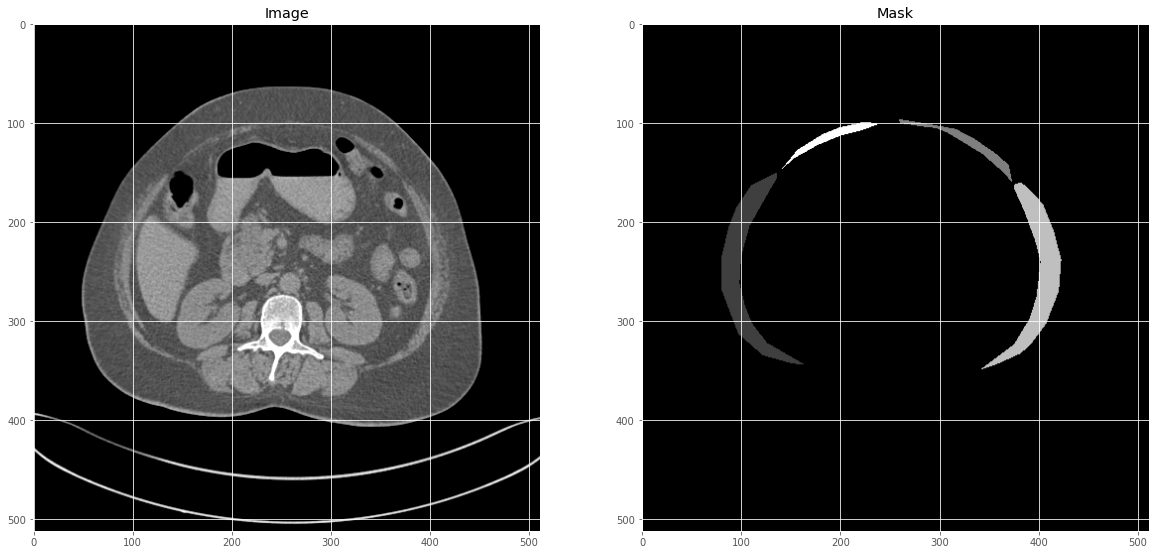

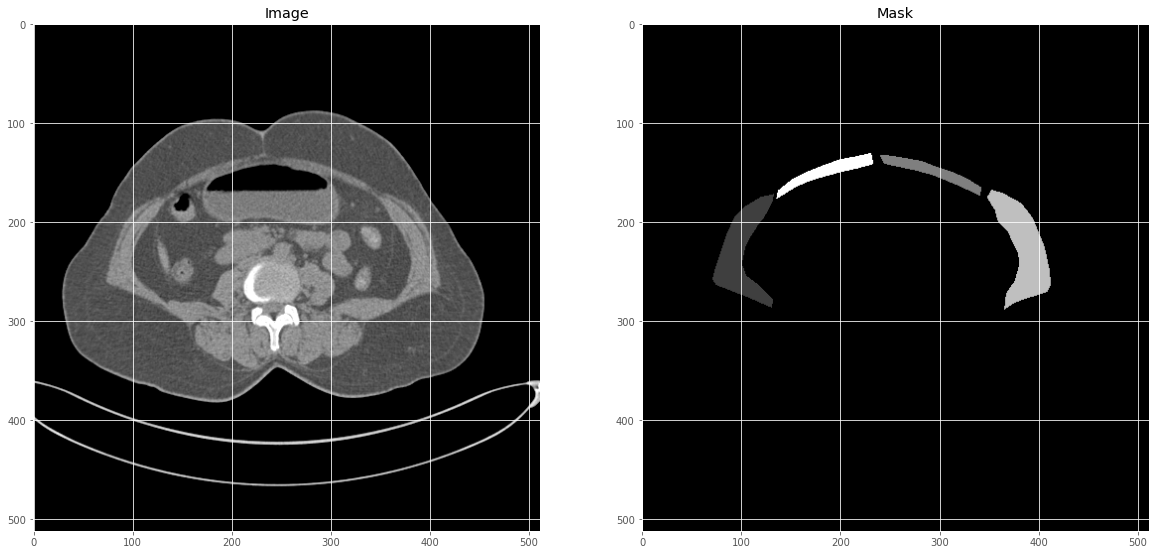

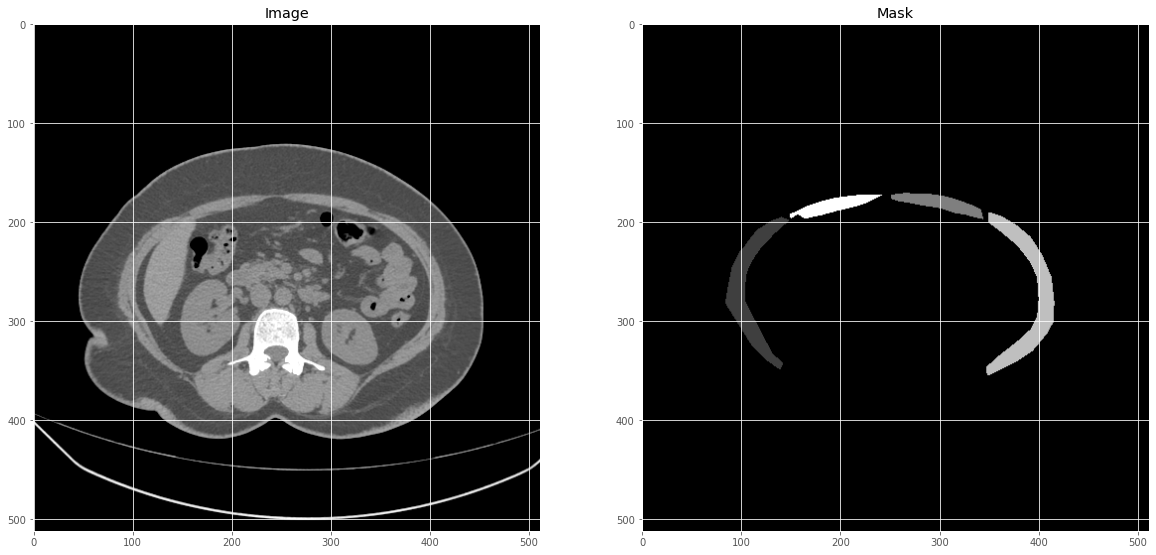

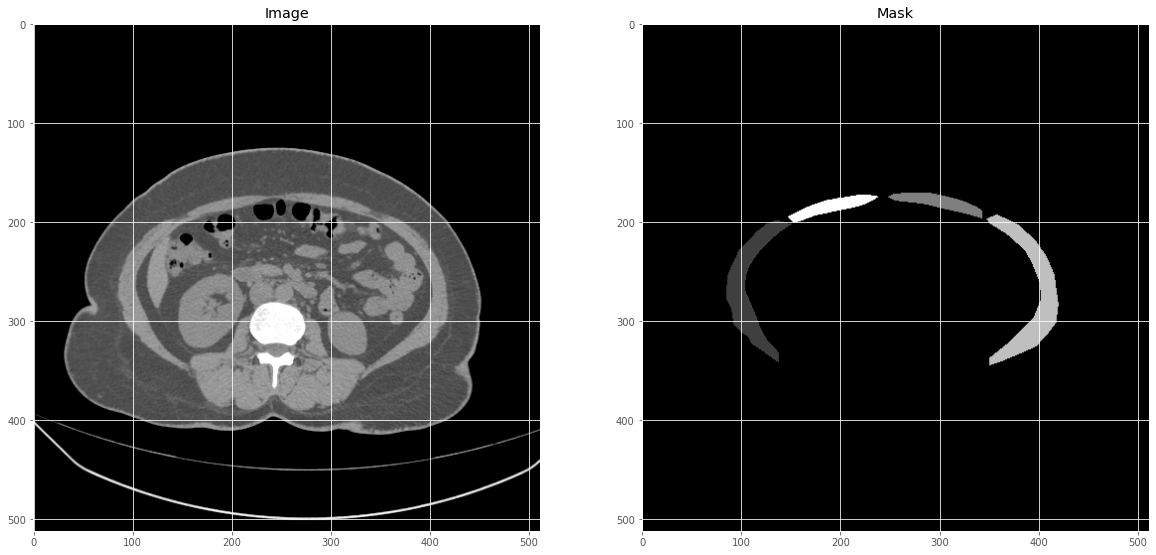

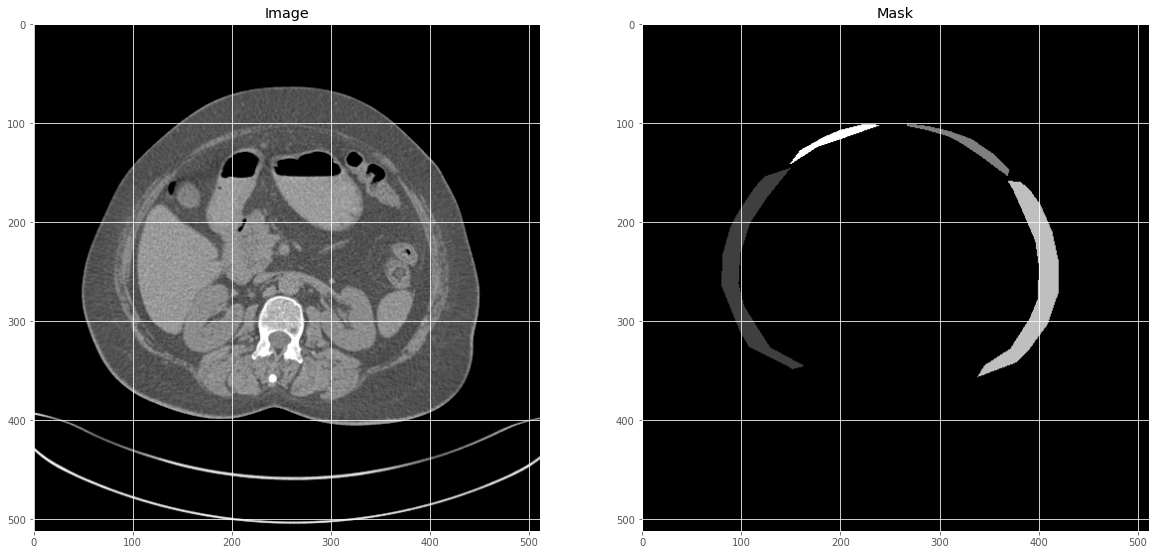

In [63]:
pre_visualize(X_train_resize, y_train_resize, train_text)

In [64]:
def avg_loss_resize():
    d_loss_train = 0
    d_loss_valid = 0
    d_loss_test = 0

    temp = 0

    d_loss_train_list = []
    d_loss_valid_list = []
    d_loss_test_list = []
    
    for i in tqdm(range(0,len(X_train))):
        temp = resize(preds_train[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_train = dice_loss(y_train_resize[i],temp).numpy()
        d_loss_train_list.append(d_loss_train)
        
    #d_loss_train_std = statistics.stdev(d_loss_train_list)
    #d_loss_train_avg = statistics.mean(d_loss_train_list)
    
    temp = 0
    
    
    for i in tqdm(range(0,len(X_valid))):
        temp = resize(preds_val[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_valid = dice_loss(y_valid_resize[i],temp).numpy()
        d_loss_valid_list.append(d_loss_valid)
        
    temp = 0
    
    for i in tqdm(range(0,len(X_test_resize))):
        temp = resize(preds_test[i], (512, 512, 1), mode = 'constant', preserve_range = True)
        #temp_2 = temp_2/255.0
        d_loss_test = dice_loss(y_test_resize[i],temp).numpy()
        d_loss_test_list.append(d_loss_test)
        
        

    #d_loss_valid_std = statistics.stdev(d_loss_valid_list)
    #d_loss_valid_avg = statistics.mean(d_loss_valid_list)
    return d_loss_train_list, d_loss_valid_list, d_loss_test_list
#d_loss_train_avg,d_loss_valid_avg,d_loss_train_std,d_loss_valid_std

In [65]:
a,b, c = avg_loss_resize() #List of training and validation values
print(len(a),len(b), len(c))


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 52.34it/s]

180 46 21


In [66]:
case_1 = c[:5:]
case_2 = c[5:10:]
case_3 = c[10:15:]
case_4 = c[15::]

In [67]:
print("Mean Dice loss of standard U-Net for training: ",statistics.mean(a), " Max : ", max(a), "Min :", min(a))
print("Mean Dice loss of standard U-Net for valid: ",statistics.mean(b), "Max : ", max(b), "Min : ", min(b))

Mean Dice loss of standard U-Net for training:  0.060987584  Max :  0.077272 Min : 0.04078144
Mean Dice loss of standard U-Net for valid:  0.06445788 Max :  0.09785539 Min :  0.043254256


In [68]:
print("Mean Dice loss of standard U-Net for test-1: ",statistics.mean(case_1), "Max : ", max(case_1), "Min : ", min(case_1))
print("Mean Dice loss of standard U-Net for test-2: ",statistics.mean(case_2), "Max : ", max(case_2), "Min : ", min(case_2))
print("Mean Dice loss of standard U-Net for test-3: ",statistics.mean(case_3), "Max : ", max(case_3), "Min : ", min(case_3))
print("Mean Dice loss of standard U-Net for test-4: ",statistics.mean(case_4), "Max : ", max(case_4), "Min : ", min(case_4))


Mean Dice loss of standard U-Net for test-1:  0.1987758 Max :  0.21105039 Min :  0.18388122
Mean Dice loss of standard U-Net for test-2:  0.12990674 Max :  0.13711303 Min :  0.12069321
Mean Dice loss of standard U-Net for test-3:  0.11363971 Max :  0.12537706 Min :  0.10514051
Mean Dice loss of standard U-Net for test-4:  0.112459056 Max :  0.14009565 Min :  0.08226335


In [70]:
print("Done")

Done
